In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

2025-10-26 18:13:40.071161: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-26 18:13:41.603624: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-26 18:13:41.603720: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-26 18:13:41.839626: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-26 18:13:42.365946: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-26 18:13:42.369220: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [4]:
# ----Part 1---- 

# Image path
data_dir = "./"

# Basic Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

# training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",# assgin the label based on the folder names "damge, no damage"
    label_mode = "int",
    validation_split = 0.2, 
    subset= "training",
    seed = SEED,
    image_size = IMG_SIZE, 
    batch_size = BATCH_SIZE
)
    
# validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 21322 files belonging to 2 classes.
Using 17058 files for training.
Found 21322 files belonging to 2 classes.
Using 4264 files for validation.


In [6]:
# Checking the Image and Label Size
for images, labels in train_ds.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
    sample_img = images[0]
    break

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)


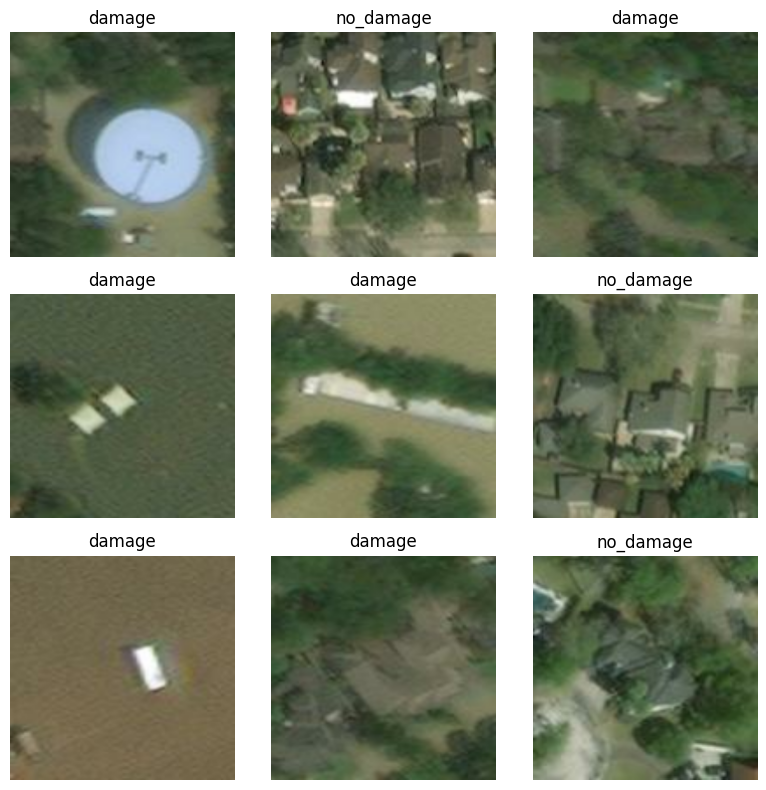

In [7]:
plt.figure(figsize=(8,8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.tight_layout()
plt.show()
